In [1]:
import quandl
import pandas as pd


In [2]:
authtoken = 'CYmZJQTZk9cM-5LUZxD_'
def get_data_quandl(symbol, start_date, end_date):
    data = quandl.get(symbol, start_date=start_date, 
                      end_date=end_date, authtoken=authtoken)
    return data


In [3]:
def generate_features(df):
    """Generate features for a stock/index based on historical price and performance
    Args:
        df(dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close")
    Returns:
        dataframe, data set with new features
        """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    # Shift index by 1, in order to take the value of previous day. For example, [1, 3, 4, 2] -> [N/A, 1, 3, 4]
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 original features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    # rolling_mean calculates the moving standard deviation given a window
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean()
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    # This will drop rows with any N/A value, which is by-product of moving average/std.
    return df_new

In [20]:
#quandl.get_table('SHARADAR/SEP', ticker=['AAPL','TSLA'])
symbol = 'EOD/AAPL'
start = '1988-01-01'
end = '2015-12-31'
data_raw = get_data_quandl(symbol, start, end)
data = generate_features(data_raw)

In [21]:
def compute_prediction(X, weights):
    """ Compute the prediction y_hat based on current weights
    Args:
    X (numpy.ndarray) 
    weights (numpy.ndarray)
    Returns:
    numpy.ndarray, y_hat of X under weights 
    """
    predictions = np.dot(X, weights)
    return predictions

In [22]:
def update_weights_gd(X_train, y_train, weights, learning_rate):
    predictions = compute_prediction(X_train, weights)
    weights_delta = np.dot(X_train.T, y_train - predictions)
    m = y_train.shape[0]
    weights += learning_rate / float(m) * weights_delta
    return weights

In [23]:
def compute_cost(X, y, weights):
    predictions = compute_prediction(X, weights)
    cost = np.mean((predictions - y) ** 2 / 2.0)
    return cost

In [24]:
def train_linear_regression(X_train, y_train, max_iter, learning_rate, fit_intercept=False):
    if fit_intercept:
        intercept = np.ones((X_train.shape[0], 1))
        X_train = np.hstack((intercept, X_train))
        weights = np.zeros(X_train.shape[1])
        for iteration in range(max_iter):
            weights = update_weights_gd(X_train, y_train, weights, learning_rate)
            if iteration % 100 == 0:
                print(compute_cost(X_train, y_train, weights))
        return weights

In [25]:
def predict(X, weights):
    if X.shape[1] == weights.shape[0] - 1:
        intercept = np.ones((X.shape[0], 1))
        X = np.hstack((intercept, X))
    return compute_prediction(X, weights)

In [26]:
import numpy as np
X_train = np.array([[6], [2], [3], [4], [1], 
                    [5], [2], [6], [4], [7]])
y_train = np.array([5.5, 1.6, 2.2, 3.7, 0.8, 
                    5.2, 1.5, 5.3, 4.4, 6.8])

In [27]:
weights = train_linear_regression(X_train, y_train, 
                                  max_iter=100, learning_rate=0.01, fit_intercept=True)

5.571972628


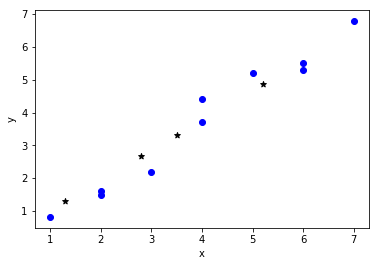

In [28]:
%matplotlib inline
X_test = np.array([[1.3], [3.5], [5.2], [2.8]])
predictions = predict(X_test, weights)
import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], y_train, marker='o', c='b')
plt.scatter(X_test[:, 0], predictions, marker='*', c='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [29]:
from sklearn.linear_model import SGDRegressor
regressor = SGDRegressor(loss='squared_loss', penalty='l2', 
                         alpha=0.0001, learning_rate='constant', eta0=0.01, max_iter=1000)

In [30]:
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)
print(predictions)

[0.99706088 3.23393923 4.96243613 2.52220521]


/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [31]:
import datetime
start_train = datetime.datetime(1988, 1, 1, 0, 0)
end_train = datetime.datetime(2014, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]

In [32]:
X_columns = list(data.drop(['close'], axis=1).columns)
y_column = 'close'
X_train = data_train[X_columns]
y_train = data_train[y_column]

In [33]:
print(X_train.shape)
y_train.shape

(83, 37)


(83,)

In [34]:
start_test = datetime.datetime(2015, 1, 1, 0, 0)
end_test = datetime.datetime(2015, 12, 31, 0, 0)
data_test = data.loc[start_test:end_test]
X_test = data_test[X_columns]
y_test = data_test[y_column]

In [35]:
X_test.shape

(252, 37)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [37]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {"alpha": [3e-06, 1e-5, 3e-5],
              "eta0": [0.01, 0.03, 0.1],
             }
lr = SGDRegressor(penalty='l2', n_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, 
                           scoring='neg_mean_absolute_error')
grid_search.fit(X_scaled_train, y_train)

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarni

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarni

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=1000, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [3e-06, 1e-05, 3e-05], 'eta0': [0.01, 0.03, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [64]:
print(grid_search.best_params_)
lr_best = grid_search.best_estimator_
predictions_lr = lr_best.predict(X_scaled_test)
predictions_lr

{'C': 1000, 'epsilon': 1e-05}


array([ 112.32790868,  110.6240213 ,  109.52291161,  109.63306242,
        111.05469808,  116.05388096,  116.00568633,  116.26829809,
        114.48100991,  113.32300766,  112.21155334,  113.23215412,
        113.49655448,  114.77032675,  117.64207561,  118.28252482,
        115.95516729,  116.09726459,  116.20974787,  112.14743432,
        108.33949318,  104.99047659,  105.76566311,  104.4529776 ,
        104.23662949,  103.72292311,  104.36571299,  105.7762671 ,
        106.49334865,  106.34911012,  102.25648491,   98.50499666,
         97.08995544,   97.58960499,   96.4386431 ,   98.05420996,
         95.32730662,   91.55513872,   86.62185343,   88.50611482,
         88.35704678,   88.49571475,   89.68331755,   88.32579038,
         88.61659788,   83.79806962,   78.60656766,   72.54301491,
         73.10576261,   73.7593394 ,   75.75005195,   78.05580182,
         78.60005483,   76.0696991 ,   72.50739697,   69.53253193,
         67.85673445,   65.77327925,   67.88784039,   68.84604

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lr)))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lr)))


MSE: 206250.040
MAE: 359.497
R^2: -3504.946


In [48]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {"max_depth": [30, 50],
              "min_samples_split": [3, 5, 10],
             }
rf = RandomForestRegressor(n_estimators=1000)
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                           scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [30, 50], 'min_samples_split': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [62]:
print(grid_search.best_params_)
rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)
predictions_rf

{'C': 1000, 'epsilon': 1e-05}


array([ 3.23674399e+08,  2.72747252e+08,  2.75249209e+08,  1.79650364e+08,
        1.05581549e+08,  6.15971224e+07,  7.32530831e+07,  9.49107182e+07,
        9.15791043e+07,  4.14920942e+07,  6.40878977e+07,  7.64647082e+07,
        6.96966641e+07,  1.29751034e+08,  1.71990977e+08,  2.14094512e+08,
        1.23863138e+08,  2.16305400e+08,  1.79817029e+08,  1.69450922e+07,
       -1.76285379e+08, -2.33130903e+08, -6.77133454e+07, -2.14304133e+08,
       -9.18169601e+07, -5.94135262e+07,  9.68690648e+06,  2.11256535e+07,
        2.90417930e+07, -1.05631638e+07, -6.28239179e+07, -1.88388820e+08,
       -7.14063103e+07,  3.72635711e+07,  3.33872366e+07,  6.33482066e+07,
        6.27803730e+07,  1.73601984e+07, -8.02979572e+07, -2.13325245e+07,
        1.31521162e+08,  3.10512397e+08,  4.51978171e+08,  3.86565755e+08,
        4.31567812e+08,  4.27614363e+08,  3.11413416e+08,  9.04123352e+07,
        1.52700138e+08,  2.49633690e+08,  3.56429707e+08,  3.78005925e+08,
        3.82660409e+08,  

In [59]:
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


MSE: 711561585567079168.000
MAE: 743014807.954
R^2: -12095497193845252.000


In [60]:
from sklearn.svm import SVR
param_grid = {"C": [1000, 3000, 10000],
              "epsilon": [0.00001, 0.00003, 0.0001],
             }
svr = SVR(kernel='linear')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_scaled_train, y_train)
print(grid_search.best_params_)
svr_best = grid_search.best_estimator_
predictions_svr = svr_best.predict(X_scaled_test)
print('MSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_svr)))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_svr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_svr)))


/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1000, 'epsilon': 1e-05}
MSE: 206250.040
MAE: 359.497
R^2: -3504.946


In [63]:
predictions_svr

array([ 112.32790868,  110.6240213 ,  109.52291161,  109.63306242,
        111.05469808,  116.05388096,  116.00568633,  116.26829809,
        114.48100991,  113.32300766,  112.21155334,  113.23215412,
        113.49655448,  114.77032675,  117.64207561,  118.28252482,
        115.95516729,  116.09726459,  116.20974787,  112.14743432,
        108.33949318,  104.99047659,  105.76566311,  104.4529776 ,
        104.23662949,  103.72292311,  104.36571299,  105.7762671 ,
        106.49334865,  106.34911012,  102.25648491,   98.50499666,
         97.08995544,   97.58960499,   96.4386431 ,   98.05420996,
         95.32730662,   91.55513872,   86.62185343,   88.50611482,
         88.35704678,   88.49571475,   89.68331755,   88.32579038,
         88.61659788,   83.79806962,   78.60656766,   72.54301491,
         73.10576261,   73.7593394 ,   75.75005195,   78.05580182,
         78.60005483,   76.0696991 ,   72.50739697,   69.53253193,
         67.85673445,   65.77327925,   67.88784039,   68.84604

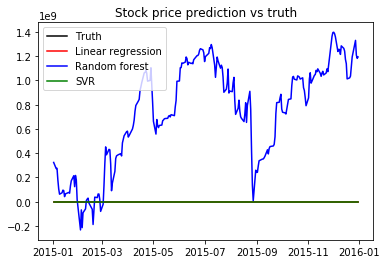

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
dates = data_test.index.values
plot_truth, = plt.plot(dates, y_test, 'k')
plot_lr, = plt.plot(dates, predictions_lr, 'r')
plot_rf, = plt.plot(dates, predictions_rf, 'b')
plot_svr, = plt.plot(dates, predictions_svr, 'g')
plt.legend([plot_truth, plot_lr, plot_rf, plot_svr], ['Truth', 'Linear regression', 'Random forest', 'SVR'])
plt.title('Stock price prediction vs truth')
plt.show()

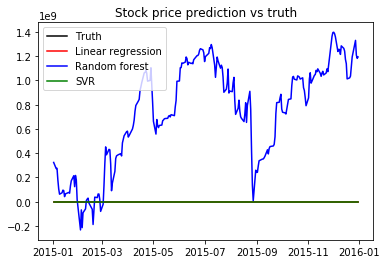

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
dates = data_test.index.values
plt.plot(dates, y_test, 'k')
plt.plot(dates, predictions_lr, 'r')
plt.plot(dates, predictions_rf, 'b')
plt.plot(dates, predictions_svr, 'g')
plt.legend([plot_truth, plot_lr, plot_rf, plot_svr], ['Truth', 'Linear regression', 'Random forest', 'SVR'])
plt.title('Stock price prediction vs truth')
plt.show()

In [66]:
dates = data_test.index.values
plot_all = plt.plot(dates, y_test, 'k', predictions_lr, 'r', predictions_rf, 'b',
                      predictions_svr, 'g')
#plot_lr, = plt.plot(dates, predictions_lr, 'r')
#plot_rf, = plt.plot(dates, predictions_rf, 'b')
#plot_svr, = plt.plot(dates, predictions_svr, 'g')
plt.legend([plot_truth, plot_lr, plot_rf, plot_svr], ['Truth', 'Linear regression', 'Random forest', 'SVR'])
plt.title('Stock price prediction vs truth')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x122857620> (for post_execute):


ValueError: view limit minimum -36798.15 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36798.15 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units